# LA Metro 720

Pick a route that is pretty long, and compare how the stops are aggregated to AM/PM peak.

In [1]:
import datetime as dt
import geopandas as gpd
import numpy as np
import pandas as pd

from siuba import *

import utilities
import A1_rail_ferry_brt as rail_ferry_brt
import B1_bus_corridors as bus_corridors

from shared_utils import rt_utils

GCS_FILE_PATH = utilities.GCS_FILE_PATH

analysis_date = rail_ferry_brt.analysis_date

import dask.dataframe as dd
import dask_geopandas


itp_id = 182
date_str = analysis_date.strftime(rt_utils.FULL_DATE_FMT)

/opt/conda/lib/python3.10/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## Eric's original method by `shape_id`

Select just the `shape_id` if it starts with 720, and compile those results

In [2]:
from shared_utils import geography_utils

import zlib

In [3]:
def single_shape_hqta(
    routelines, trips, stop_times, stops, route_count_by_stop, shape_id, hqta
):
    """Starting with a single GTFS shape, split that shape into segments and determine if each segment qualifies
    as an HQTA. Existing segments within a shape are dropped for that shape, since their peak frequency and
    HQTA status would have already been calculated for a previous shape.
    """

    single_line = routelines >> filter(_.shape_id == shape_id)
    if single_line.size == 0 or single_line.geometry.isna().all():
        print(f"no geometry for shape {shape_id}")
        return
    
    debug_ids = []
    if shape_id in debug_ids:
        print(f"***debug shape*** {shape_id}")
        debug_dict[f"{shape_id}_single_line"] = single_line
        debug_dict[f"{shape_id}_hqta"] = hqta

    calculated_stops = []
    ## TODO any way to make more efficient? a pre-calculated shape overlap? something else?
    if hqta.size != 0:
        already_calculated = hqta.dissolve(
            by="calitp_itp_id"
        )  ## get single polygon of HQTA calculation complete area
        single_line = single_line.overlay(
            already_calculated, how="difference"
        )  ## drop calculation complete area from current shape
        if single_line.size == 0:
            segments_with_max_stop = None
            print(f"already calculated corridor for shape {shape_id}")
            return

    segmented = gpd.GeoDataFrame() ##changed to gdf?
    for segment in utilities.create_segments(single_line.geometry):
        to_append = single_line.drop(columns=["geometry"])
        to_append["geometry"] = segment
        segmented = pd.concat((segmented, to_append))

    segmented = segmented.reset_index()
    if shape_id in debug_ids:
        debug_dict[f"{shape_id}_a_segmented"] = segmented

    try:
        segmented["segment_sequence"] = segmented.index.astype(str)
        assert 'calitp_itp_id' in segmented.columns
        # segmented = segmented.astype({"calitp_itp_id": str}) ## casting this to string is bad for exports...
        ## instead, cast when generating segment id below...
    except:
        print(f"segmented shape has no itp_id {shape_id}")
        return

    ## compute (hopefully unique) hash of segment id that can be used across routes/operators
    segmented["hqta_segment_id"] = segmented.apply(
        lambda x: zlib.crc32(
            (str(x.calitp_itp_id) + x.shape_id + x.segment_sequence).encode("utf-8")
        ),
        axis=1,
    )

    segmented.geometry = segmented.buffer(
        50
    )  ##generous buffer for street/sidewalk width? Required to spatially find stops within each segment

    if shape_id in debug_ids:
        debug_dict[f"{shape_id}_segmented"] = segmented
        debug_dict[f"{shape_id}_stops"] = stops
        debug_dict[f"{shape_id}_route_ct_by_stop"] = route_count_by_stop

    segments_with_max_stop = segmented.apply(
        utilities.find_stop_with_high_trip_count,
        axis=1,
        args=(stops, stop_times, 1, calculated_stops),
    )

    if not "stop_id" in segments_with_max_stop.columns:
        segments_with_top2_stops = None
        print(f"no stops for shape {shape_id}")
        return  ## no stops within segment

    max_stop_times = (
        stop_times
        >> select(_.stop_id, _.trip_id, _.departure_time)
        >> inner_join(_, segments_with_max_stop, on="stop_id")
    )  ## filter stop_times to the key stops in each segment
    max_stop_times = max_stop_times.dropna(subset=["departure_time"])
    max_stop_times = max_stop_times.drop_duplicates(
        subset=["trip_id", "hqta_segment_id"]
    )  ## filter duplicates for top2 approach

    if shape_id in debug_ids:
        debug_dict[f"{shape_id}_max_stop0"] = max_stop_times

    max_stop_times["departure_time"] = max_stop_times["departure_time"].apply(
        utilities.fix_arrival_time
    )  ## reformat GTFS time to a format datetime can ingest
    max_stop_times["departure_dt"] = max_stop_times["departure_time"].apply(
        lambda x: dt.datetime.strptime(x, "%H:%M:%S")
    )
    max_stop_times["departure_hour"] = max_stop_times["departure_dt"].apply(
        lambda x: x.hour
    )

    if max_stop_times.size == 0:
        print(f"no commute hour trips for shape {shape_id}")
        return

    if shape_id in debug_ids:
        debug_dict[f"{shape_id}_max_stop"] = max_stop_times

    ## new flexible peak
    segment_am_max = (
        max_stop_times
        >> count(_.hqta_segment_id, _.departure_hour)
        >> filter(_.departure_hour < 12)
        >> group_by(_.hqta_segment_id)
        >> summarize(am_max_trips=_.n.max())
    )

    segment_pm_max = (
        max_stop_times
        >> count(_.hqta_segment_id, _.departure_hour)
        >> filter(_.departure_hour >= 12)
        >> group_by(_.hqta_segment_id)
        >> summarize(pm_max_trips=_.n.max())
    )
    try:
        segment_peak_service = segment_am_max >> inner_join(
            _, segment_pm_max, on="hqta_segment_id"
        )
        segment_peak_service["hq_transit_corr"] = segment_peak_service.apply(
            lambda x: x.am_max_trips > 4 and x.pm_max_trips > 4, axis=1
        )
    except:  ## append when all segments only have am or pm trips, not an hqta by definition
        segment_peak_service = pd.concat((segment_am_max, segment_pm_max))
        segment_peak_service["hq_transit_corr"] = False

    segment_peak_service = segment_peak_service.reset_index(drop=True)

    single_hqta = segments_with_max_stop >> inner_join(
        _, segment_peak_service, on="hqta_segment_id"
    )
    single_hqta = single_hqta >> select(-_.calitp_extracted_at, -_.index, -_.n_trips)

    if shape_id in debug_ids:
        debug_dict[f"{shape_id}_single_hqta"] = single_hqta

    return single_hqta.reset_index(drop=True)

In [4]:
FILE_PATH = f"{rt_utils.GCS_FILE_PATH}cached_views/"


def single_operator_hqta(itp_id, analysis_date):

    global debug_dict
    debug_dict = {}
    
    '''
    # shapes, trips, stop_times, stops = views
    routelines = rt_utils.get_routelines(itp_id, analysis_date)
    ## force clear to ensure route type data present
    trips = rt_utils.get_trips(itp_id, analysis_date, force_clear=True, route_types = ['3'])
    stop_times = rt_utils.get_stop_times(itp_id, analysis_date)
    stops = rt_utils.get_stops(itp_id, analysis_date)
    '''
    date_str = analysis_date.strftime(rt_utils.FULL_DATE_FMT)

    routelines = gpd.read_parquet(f"{FILE_PATH}routelines_{itp_id}_{date_str}.parquet")
    trips = pd.read_parquet(f"{FILE_PATH}trips_{itp_id}_{date_str}.parquet")
    stop_times = pd.read_parquet(f"{FILE_PATH}st_{itp_id}_{date_str}.parquet")
    stops = gpd.read_parquet(f"{FILE_PATH}stops_{itp_id}_{date_str}.parquet")
    
    distinct_routes = (
        trips
        >> distinct(_.route_id, _.shape_id, _.direction_id, _keep_all=True)
        >> select(_.calitp_itp_id, _.route_id, _.shape_id, _.direction_id, _.trip_id)
    )
    
    distinct_routes = distinct_routes[
        distinct_routes.shape_id.str.startswith("720")].reset_index(drop=True)

    route_count_by_stop = (
        stop_times
        >> select(_.stop_id, _.trip_id)
        >> inner_join(_, distinct_routes, on="trip_id")
        >> count(_.stop_id)
        >> rename(n_routes=_.n)
        >> arrange(-_.n_routes)
    )

    hqta = gpd.GeoDataFrame()
    ## start with shapes including the highest number of trips
    trips_shape_sorted = (
        trips[trips.shape_id.str.startswith("720")].groupby("shape_id")
        .count()
        .sort_values(by="trip_id", ascending=False)
        .index
    )
    trips_shape_sorted = pd.Series(trips_shape_sorted)
    total_shapes = len(trips_shape_sorted)
    print(f"there are {total_shapes} shapes total")
    for ix, shape_id in trips_shape_sorted.items():
        print(f"calculating for shape_id {shape_id}")
        if ix % 25 == 0:
            print(
                f"progress: {ix}/{total_shapes} shapes ({round(((ix/total_shapes)*100), 2)}%)"
            )
        # try:
        result = single_shape_hqta(
            routelines, trips, stop_times, stops, route_count_by_stop, shape_id, hqta
        )
        hqta = pd.concat((hqta, result))
        # except:
            # print(f"unable to calculate HQTA for shape_id {shape_id}")
        try:
            hqta = hqta.set_crs(geography_utils.CA_NAD83Albers)
        except:
            continue
    return hqta
    # return hqta.drop(columns=['n', 'departure_hour']).reset_index(drop=True)

In [ ]:
operator = single_operator_hqta(itp_id, analysis_date)
operator.to_parquet("./data/eric_720.parquet")

In [6]:
# Import data
FILE_PATH = f"{rt_utils.GCS_FILE_PATH}cached_views/"

routelines = gpd.read_parquet(
    f"{FILE_PATH}routelines_{itp_id}_{date_str}.parquet")
trips = pd.read_parquet(f"{FILE_PATH}trips_{itp_id}_{date_str}.parquet")
stop_times = pd.read_parquet(f"{FILE_PATH}st_{itp_id}_{date_str}.parquet")
stops = gpd.read_parquet(f"{FILE_PATH}stops_{itp_id}_{date_str}.parquet")

In [9]:
def subset(routelines, trips, stop_times, stops):
    routelines2 = (routelines[routelines.shape_id.str.startswith("720")]
                   .reset_index(drop=True)
                  )
    trips2 = (trips[trips.shape_id.str.startswith("720")]
              .reset_index(drop=True)  
             )
    stop_times2 = (stop_times[stop_times.trip_key.isin(trips2.trip_key)]
                   .reset_index(drop=True)  
                  )
    stops2 = (stops[stops.stop_id.isin(stop_times2.stop_id)]
              .reset_index(drop=True)
             )
    
    return routelines2, trips2, stop_times2, stops2


In [10]:
routelines720, trips720, stop_times720, stops720 = subset(
    routelines, trips, stop_times, stops)

In [17]:
test_shape = routelines720.shape_id[0]

In [20]:
single_line = routelines720 >> filter(_.shape_id == test_shape)
   
segmented = gpd.GeoDataFrame() ##changed to gdf?
for segment in utilities.create_segments(single_line.geometry):
    to_append = single_line.drop(columns=["geometry"])
    to_append["geometry"] = segment
    segmented = pd.concat((segmented, to_append))

segmented = segmented.reset_index()

segmented["segment_sequence"] = segmented.index.astype(str)

## compute (hopefully unique) hash of segment id that can be used across routes/operators
segmented["hqta_segment_id"] = segmented.apply(
    lambda x: zlib.crc32(
        (str(x.calitp_itp_id) + x.shape_id + x.segment_sequence).encode("utf-8")
    ),
    axis=1,
)

segmented.geometry = segmented.buffer(
    50
)  ##generous buffer for street/sidewalk width? Required to spatially find stops within each segment

In [23]:
calculated_stops = []
segments_with_max_stop = segmented.apply(
    utilities.find_stop_with_high_trip_count,
    axis=1,
    args=(stops, stop_times, 1, calculated_stops),
)

In [27]:
segments_with_max_stop.columns

Index(['index', 'calitp_itp_id', 'calitp_url_number', 'shape_id', 'geometry',
       'segment_sequence', 'hqta_segment_id', 'stop_id', 'n_trips'],
      dtype='object')

<AxesSubplot:>

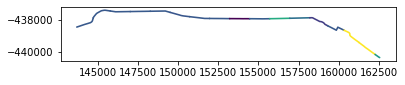

In [28]:
segments_with_max_stop.plot(column="n_trips")

In [32]:
segments_with_max_stop.stop_id.nunique()

16

In [29]:
max_stop_times = (
    stop_times
    >> select(_.stop_id, _.trip_id, _.departure_time)
    >> inner_join(_, segments_with_max_stop, on="stop_id")
)  ## filter stop_times to the key stops in each segment
max_stop_times = max_stop_times.dropna(subset=["departure_time"])
max_stop_times = max_stop_times.drop_duplicates(
    subset=["trip_id", "hqta_segment_id"]
)  ## filter duplicates for top2 approach


In [33]:
max_stop_times.stop_id.nunique()

16

In [34]:
max_stop_times["departure_time"] = max_stop_times["departure_time"].apply(
    utilities.fix_arrival_time
)  ## reformat GTFS time to a format datetime can ingest
max_stop_times["departure_dt"] = max_stop_times["departure_time"].apply(
    lambda x: dt.datetime.strptime(x, "%H:%M:%S")
)
max_stop_times["departure_hour"] = max_stop_times["departure_dt"].apply(
    lambda x: x.hour
)

Index(['stop_id', 'trip_id', 'departure_time', 'index', 'calitp_itp_id',
       'calitp_url_number', 'shape_id', 'geometry', 'segment_sequence',
       'hqta_segment_id', 'n_trips'],
      dtype='object')

In [39]:
max_stop_times[max_stop_times.departure_hour < 12].groupby(
    ["hqta_segment_id"]
).agg({"n_trips": "count"}).reset_index()

,hqta_segment_id,n_trips
0,446356391,184
1,502734782,396
2,918098596,77
3,945986198,240
4,1057971855,240
5,1102979634,248
6,1208512025,236
7,1332062720,240
8,1839065905,240
9,2207484445,294


In [45]:
# This is the equivalent calculation 
# Make sure I'm doing this, otherwise, counts won't match
(max_stop_times.groupby(["hqta_segment_id", "departure_hour"])
 .agg({"trip_id": "count"})
 .reset_index()
 .groupby(["hqta_segment_id"])
 .agg({"trip_id": "max"})
 .reset_index()
)

,hqta_segment_id,trip_id
0,446356391,11
1,502734782,27
2,918098596,5
3,945986198,15
4,1057971855,15
5,1102979634,18
6,1208512025,16
7,1332062720,15
8,1839065905,15
9,2207484445,20


In [43]:
(
    max_stop_times
    >> count(_.hqta_segment_id, _.departure_hour)
    >> filter(_.departure_hour < 12)
    >> group_by(_.hqta_segment_id)
    >> summarize(am_max_trips=_.n.max())
)

,hqta_segment_id,am_max_trips
0,446356391,11
1,502734782,27
2,918098596,4
3,945986198,15
4,1057971855,14
5,1102979634,16
6,1208512025,14
7,1332062720,15
8,1839065905,15
9,2207484445,20


In [35]:


## new flexible peak
segment_am_max = (
    max_stop_times
    >> count(_.hqta_segment_id, _.departure_hour)
    >> filter(_.departure_hour < 12)
    >> group_by(_.hqta_segment_id)
    >> summarize(am_max_trips=_.n.max())
)

segment_pm_max = (
    max_stop_times
    >> count(_.hqta_segment_id, _.departure_hour)
    >> filter(_.departure_hour >= 12)
    >> group_by(_.hqta_segment_id)
    >> summarize(pm_max_trips=_.n.max())
)

In [36]:
segment_am_max

,hqta_segment_id,am_max_trips
0,446356391,11
1,502734782,27
2,918098596,4
3,945986198,15
4,1057971855,14
5,1102979634,16
6,1208512025,14
7,1332062720,15
8,1839065905,15
9,2207484445,20


## Tiff's method, use dask 

In [ ]:
# Import data
FILE_PATH = f"{rt_utils.GCS_FILE_PATH}cached_views/"

routelines = dask_geopandas.read_parquet(
    f"{FILE_PATH}routelines_{itp_id}_{date_str}.parquet")
trips = dd.read_parquet(f"{FILE_PATH}trips_{itp_id}_{date_str}.parquet")
stop_times = dd.read_parquet(f"{FILE_PATH}st_{itp_id}_{date_str}.parquet")
stops = dask_geopandas.read_parquet(f"{FILE_PATH}stops_{itp_id}_{date_str}.parquet")

In [ ]:
operator2 = bus_corridors.single_operator_hqta(routelines, trips, stop_times, stops)

operator2.to_parquet("./data/tiff_720.parquet")

## Compare

In [ ]:
def stats(df):
    df = df[df.shape_id.str.startswith("720")]
    print(df.columns)
    print(df.dtypes)
    print(f"# obs: {len(df)}")
    print(f"# unique stops: {df.stop_id.nunique()}")
    print(f"sum am_max stops: {df.am_max_trips.sum()}")
    print(f"sum pm_max stops: {df.am_max_trips.sum()}")
    print(f"# unique hqta_segment_id: {df.hqta_segment_id.nunique()}")

    
def compare(eric, tiff):
    print("***********Eric************")
    stats(eric)
    print("***********Tiff************")
    stats(tiff)

In [ ]:
compare(operator, operator2)

In [ ]:
operator.plot(column="hqta_segment_id")

In [ ]:
operator2[operator2.shape_id.str.startswith("720")].plot(column="hqta_segment_id")

In [ ]:
m1 = pd.merge(
    operator,
    operator2, 
    on = ["calitp_itp_id", "calitp_url_number", "shape_id", "stop_id"],
    how = "outer",
    indicator=True
)

In [ ]:
operator.stop_id.unique()

In [ ]:
operator2[operator2.shape_id.str.startswith("720")].stop_id.unique()

In [ ]:
operator.shape_id.value_counts()

In [ ]:
operator2[operator2.shape_id.str.startswith("720")].shape_id.value_counts()

In [ ]:
trips720 = trips[trips.shape_id.str.startswith("720")].compute()
stop_times720 = stop_times[stop_times.trip_key.isin(trips720.trip_key)].compute()
stops720 = stops[stops.stop_id.isin(stop_times720.stop_id)].compute()

In [ ]:
stop_times720["departure_time"] = stop_times720.departure_time.apply(
    utilities.fix_arrival_time)
stop_times720["departure_dt"] = stop_times720["departure_time"].apply(
        lambda x: dt.datetime.strptime(x, "%H:%M:%S")
    )
stop_times720["departure_hour"] = stop_times720["departure_dt"].apply(
    lambda x: x.hour
)

In [ ]:
distinct_routes = (
    trips.compute()
    >> distinct(_.route_id, _.shape_id, _.direction_id, _keep_all=True)
    >> select(_.calitp_itp_id, _.route_id, _.shape_id, _.direction_id, _.trip_id)
)

In [ ]:
distinct_routes = distinct_routes[
    distinct_routes.shape_id.str.startswith("720")].reset_index(drop=True)

route_count_by_stop = (
    stop_times.compute()
    >> select(_.stop_id, _.trip_id)
    >> inner_join(_, distinct_routes, on="trip_id")
    >> count(_.stop_id)
    >> rename(n_routes=_.n)
    >> arrange(-_.n_routes)
)

In [ ]:
single_shape_hqta()